# IPP Baselines

In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
from time import time
import tensorflow as tf

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params

from sgptools.models.cma_es import *
from sgptools.models.continuous_sgp import *
from sgptools.models.greedy_sgp import *
from sgptools.models.greedy_mi import *
from sgptools.models.bo import *
from sgptools.models.core.transformations import IPPTransform

import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
SAMPLING_RATE=0.01

# Convert a given path to the data (X, y) alongst the whole path
def path2data(path, X, y):
    data_X = []
    data_y = []
    num_robots, _, _ = path.shape
    for r in range(num_robots):
        X_new, y_new = cont2disc(interpolate_path(path[r], SAMPLING_RATE), 
                                 X, y)
        data_X.extend(X_new)
        data_y.extend(y_new)
    return np.array(data_X), np.array(data_y)

# Plot the solution paths
def plot_paths(paths, title=None):
    plt.figure()
    for i, path in enumerate(paths):
        plt.plot(path[:, 0], path[:, 1], 
                    c='r', label='Path', zorder=1, marker='o')
    if title is not None:
        plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')

# Get the data and initial SGP parameters

2024-05-05 11:51:11.997095: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.62774           │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [0.33841 0.33709] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.02162           │
╘═══════════════

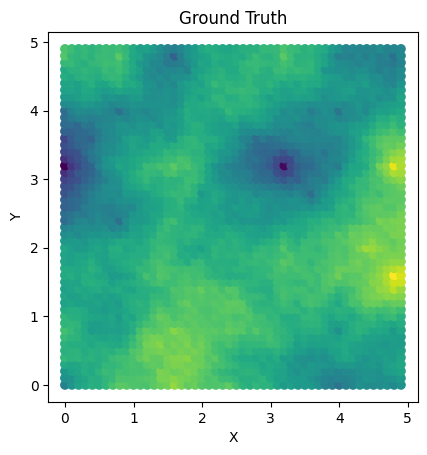

In [3]:
# Get the synthetic elevation data
dataset = 'synthetic'

num_robots = 3
num_placements = 10

X_train, y_train, X_test, y_test, candidates, X, y = get_dataset(dataset)

# Train the GP and get the model parameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], 
                                             optimizer='scipy')
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=0)
plt.title("Ground Truth")
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')
plt.show()

 # Generate IPP solutions with each method
 ### (RMSE is evaluated with a continuous sensing model)

In [4]:
# Initialize the initial IPP solution waypoints (used in all the methods)
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots,
                     max_dist=30,
                     resample=num_placements)
Xu_init = Xu_init.reshape(-1, 2)

 ## Continuous-SGP solution with point sensing model

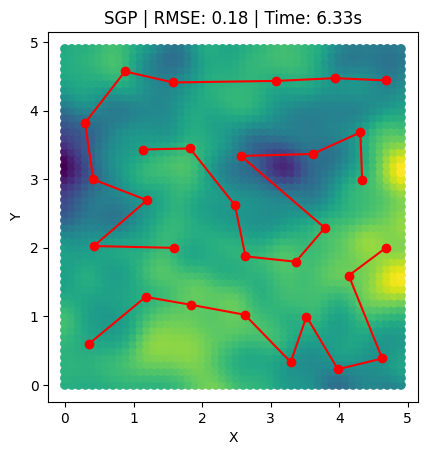

In [5]:
transform = IPPTransform(num_robots=num_robots,
                             num_dim=2)
sgp_start = time()
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=5000)
sgp_end = time()
sgp_time = sgp_end - sgp_start

# Get solution inducing points
sgp_sol = sgpr.inducing_variable.Z.numpy()
sol_paths = sgp_sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)

# Compute RMSE
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)
sgp_rmse = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"SGP | RMSE: {sgp_rmse:.2f} | Time: {sgp_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0)
plt.gca().set_aspect('equal')

 ## Continuous-SGP solution with continuous sensing model (sampling rate = 10)

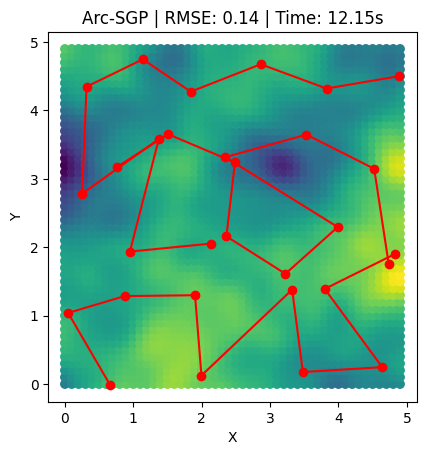

In [6]:
transform = IPPTransform(num_robots=num_robots,
                         num_dim=2,
                         sampling_rate=10)
sgp_start = time()
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=5000)
sgp_end = time()
sgp_time = sgp_end - sgp_start

# Get solution inducing points
sgp_sol = sgpr.inducing_variable.Z.numpy()
sol_paths = sgp_sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)

# Compute RMSE
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)
sgp_rmse = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"Arc-SGP | RMSE: {sgp_rmse:.2f} | Time: {sgp_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0)
plt.gca().set_aspect('equal')

 ## Greedy Mutual Information-based solution

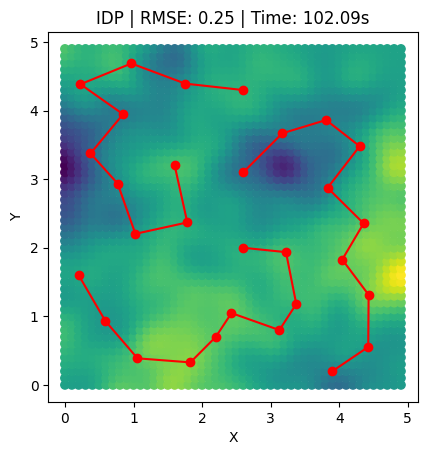

In [7]:
mi_start = time()
mi_sol = get_greedy_sgp_sol(num_placements*num_robots, 
                            candidates, 
                            candidates, 
                            noise_variance, 
                            kernel)
mi_end = time()
mi_time = mi_end - mi_start
sol_paths, _ = run_tsp(mi_sol.reshape(-1, 2), 
                       num_vehicles=num_robots,
                       max_dist=30,
                       resample=num_placements)
sol_paths = sol_paths.reshape(num_robots, 
                              num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)

# Compute RMSE
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)
mi_rmse = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"IDP | RMSE: {mi_rmse:.2f} | Time: {mi_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0)
plt.gca().set_aspect('equal')

 ## Genetic algorithm-based solution that maximizes Mutual Information

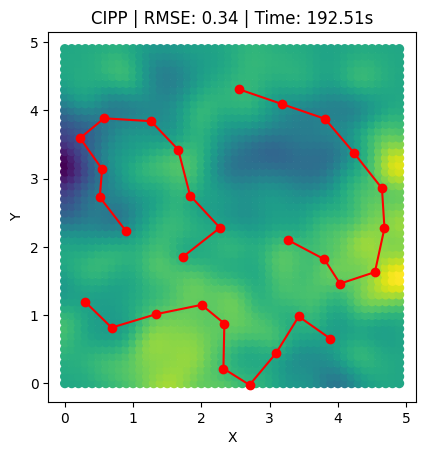

In [8]:
cma_start = time()
cma_sp = CMA_ES(candidates, noise_variance, kernel)
cma_sol = cma_sp.optimize(num_sensors=num_placements*num_robots, 
                          max_steps=2500,
                          tol=1e-2, 
                          X_init=Xu_init)
cma_end = time()
cma_time = cma_end - cma_start
sol_paths, _ = run_tsp(cma_sol.reshape(-1, 2), 
                       num_vehicles=num_robots,
                       max_dist=30,
                       resample=num_placements)
sol_paths = sol_paths.reshape(num_robots, 
                            num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)

# Compute RMSE
cma_rmse = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"CIPP | RMSE: {cma_rmse:.2f} | Time: {cma_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0)
plt.gca().set_aspect('equal')